In [79]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../..")
from mfilter.implementations.simulate import SimulateSignal
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *
from microlensing.lib.microlensing import *

%matplotlib inline
plt.style.use('seaborn')

# Match Filter with Regressor and NFFT
#### Comparing result by doing a linear regressor and a NFFT iterative solver for compute Inverse Fourier Transform


In [80]:
# generating time samples
def time_irreg_samples(n=100, basic_dt=1, struct="slight"):
    return TimesSamples(n=n, delta=basic_dt, struct=struct)

# creating templates
def mlens_temp(times, pars, idx=0, t0=None):
    if t0 is None:
        t0 = np.random.random() * times.duration*0.9 + times.min() + times.duration * 0.05
    ml = microlens(tE=pars['tE'][idx], U0=pars['U0'][idx], fs=pars['fs'][idx], t0=t0)
    return TimeSeries(ml.eval(times), times=times), t0


# generate parameter generator object and sample parameters
parfile = "test.txt" # here put your favourite file with columns tE, U0 and fs, in data directory
pargen = microlens_pars(parsfile = "../../microlensing/data/%s" % parfile)
nsample = 100
pars = pargen.sample(nsample)

In [81]:
# using the chi statistic

def power_chisq(htilde, stilde, num_bins, times, psd=None, method="regression", **kwargs):
    
    bins = power_chisq_bins(htilde, num_bins, psd=psd, method=method, **kwargs)
    
    
    snr, corr, norm = matched_filter_core(htilde, stilde, psd=psd, times=times, method=method, **kwargs)
    
    return power_chisq_from_precomputed(corr, snr, norm, bins, times, method=method, **kwargs), len(bins)

def power_chisq_bins(htilde, num_bins, psd=None, method="regression", **kwargs):
    sigma_vec = sigmasq_series(htilde, psd=psd)
    
    return power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins)

def sigmasq_series(htilde, psd=None):
    autocorr = htilde.conj() * htilde
    if psd is not None:
        autocorr /= psd
    return autocorr.cumsum()

def power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins):
    sigmasq = sigma_vec[len(sigma_vec)-2]
    edge_vec = np.arange(0, num_bins) * sigmasq / num_bins
    bins = np.searchsorted(sigma_vec, edge_vec, side='right')
    bins = np.append(bins, len(sigma_vec) - 1)
    bins = np.unique(bins)
#     if len(bins) != num_bins + 1:
#         print("using {} bins instead of {}".format(len(bins), num_bins))
    return bins

def power_chisq_from_precomputed(corr, snr, norm, bins, times, method="regression", **kwargs):
    qtilde = FrequencySeries(np.zeros(len(corr)), frequency_grid=corr.frequency_object, dtype=corr.dtype,
                            epoch=corr.epoch)
    chisq = TimeSeries(np.zeros(len(snr)), times=snr.times, dtype=snr.dtype, epoch=snr.epoch)
    num_bins = len(bins) - 1
    
    for j in range(num_bins):
        k_min = int(bins[j])
        k_max = int(bins[j+1])
        qtilde[k_min:k_max] = corr[k_min:k_max]
        q = qtilde.to_timeseries(method=method, times=times, **kwargs)
        qtilde.fill(0)
        chisq += q.squared_norm()
        
    chisq = (chisq * num_bins - snr.squared_norm()) * (norm ** 2)
    chisq = TimeSeries(chisq, times=snr.times, epoch=snr.epoch)
    return chisq

def weighted_snr(snr, chisq):
    for i in range(len(chisq)):
        if chisq[i] > 1:
            snr[i] /= ((1 + chisq[i]**(3))/2.0)**(1.0/6)
        
    return snr


In [1]:
n = 100
delta_t = 0.8
times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
times -= min(times)

def one_run(times, pars, nsample, noise_level=1, idx=None, t0=None, 
            chi=False, band=False, window=False, psd=False):
    if idx is None:
        idx = np.random.randint(1, nsample)
    data, t0 = mlens_temp(times, pars, idx=idx, t0=t0)
    while (any(np.isnan(d) for d in data)):
        idx = np.random.randint(1, nsample)
        data, t0 = mlens_temp(times, pars, idx=idx, t0=t0)
    plt.plot(times, data, '--')
    data += np.random.normal(0, noise_level, n)
    temp, _ = mlens_temp(times, pars, idx=idx, t0=times[n//2])
    plt.plot(times, data)
    plt.plot(times, temp)
    if band:
        cutoff = 0.2
        bb, ab = signal.butter(3, cutoff*2 * len(times)/times.duration, btype='lowpass', analog=False)
        data = TimeSeries(signal.filtfilt(bb, ab, data), times=times)
        temp = TimeSeries(signal.filtfilt(bb, ab, temp), times=times)
        
    if window:
        wind = signal.windows.hann(len(times))
        wind = signal.windows.tukey(len(times), alpha=1/8)
        data *= wind
        temp *= wind
        
    # create regresssors
    nyq = 1 / (2 * delta_t)
    samples_per_peak = 5
    df = 1 / times.duration / samples_per_peak
    freqs = FrequencySamples(input_time=times,
                        minimum_frequency=samples_per_peak * df,
                        maximum_frequency=nyq + samples_per_peak * df,
                        samples_per_peak=samples_per_peak)
    F = Dictionary(times, freqs)
    reg = RidgeRegression(alpha=10**(-6), phi=F)
    reg = SGDRegression(alpha=10**(-3), max_iter=10, phi=F)

    # compute transforms with regressors
    t_i = time.time()
    stilde_reg = data.to_frequencyseries(method="regression", reg=reg)
    htilde_reg = temp.to_frequencyseries(method="regression", reg=reg)
    t_f = time.time()
    print("time for reg", (t_f-t_i))
    #compute transforms with NFFT
    t_i = time.time()
    stilde_nfft = data.to_frequencyseries(method="nfft")
    htilde_nfft = temp.to_frequencyseries(method="nfft")
    t_f = time.time()
    print("time for nfft", (t_f-t_i))
    
    #lets use psd related to same noise distribution
#     psd_reg = freqs.lomb_scargle(times, np.random.normal(0, 0.1, n), norm="standard")
            
    # do MF for regressors
    t_i = time.time()
    snr_reg = matched_filter(htilde_reg, stilde_reg, psd=psd, method="regression", reg=reg, 
                        times=times, unitary_energy=True)
    t_f = time.time()
    print("time for reg is", (t_f-t_i))
    # do MF for NFFT
    t_i = time.time()
    snr_nfft = matched_filter(htilde_nfft, stilde_nfft, psd=psd, method="nfft", 
                          times=times, unitary_energy=True)
    t_f = time.time()
    print("time for nfft is", (t_f-t_i))
    if chi:
        divs = 40
        chsq_reg, n_bins = power_chisq(htilde_reg, stilde_reg, divs, times, reg=reg)
        chsq_reg /= (n_bins * 2) - 2
        chsq_nfft, n_bins = power_chisq(htilde_reg, stilde_reg, divs, times, method="nfft")
        chsq_nfft /= (n_bins * 2) - 2
    
        snr_reg = weighted_snr(snr_reg, chsq_reg)
        snr_nfft = weighted_snr(snr_nfft, chsq_nfft)
    return data, temp, snr_reg, snr_nfft, t0, idx


def compare_match(times, pars, nsample, idx=15, window=False, chi=False):
    
    data, temp, snr_reg, snr_nfft, true_t0, idx = one_run(times, pars, nsample, idx=idx, 
                                                          window=window, chi=chi)
    print(idx)
    print("true t0 is:", true_t0)
    t_max_snr_reg = np.argmax(snr_reg.real)
    t_max_snr_nfft = np.argmax(snr_nfft.real)
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))
    ax1.plot(times, snr_reg.real, 'r')
    ax2.plot(times, snr_nfft.real, 'b')
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))
    ax1.plot(times, data, 'k')
#     t_reg = np.copy(times.value) - times[t_max_snr_reg]
#     for i in range(len(t_reg)):
#         if t_reg[i] < min(times):
#             t_reg[i] = max(times) + t_reg[i]
#     idx = np.argmin(t_reg)
#     ax1.plot(np.roll(t_reg, -idx), np.roll(temp, -idx), 'r')
    temp_reg, _ = mlens_temp(times, pars, idx=idx, 
                             t0=(times[len(times)//2] - times[np.argmax(snr_reg.real)]) % times.duration)
    temp_nfft, _ = mlens_temp(times, pars, idx=idx, 
                              t0=(times[len(times)//2] - times[np.argmax(snr_nfft.real)]) % times.duration)
    ax1.plot(times, temp_reg, 'r')
    ax2.plot(times, data, 'k')
    ax2.plot(times, temp_nfft, 'b')

compare_match(times, pars, nsample, window=True, chi=False)

NameError: name 'time_irreg_samples' is not defined

Some kind of cuantification of aliasing is to run several times the match for same type of data (same template constructor) and with different sampling structure,  this should lead to different aliasing impact which are going to affect whether the detection occurs or not

In [75]:
def repeat(times, pars, nsample, N, idx=15, tol=0.1, chi=False, band=False, 
           window=False, psd=False, t0=None):
    goods_reg = 0
    goods_nfft = 0
    limit = times.duration * tol
    for i in range(N):
        data, temp, snr_reg, snr_nfft, t0 = one_run(times, pars, nsample, idx=idx, noise_level=0.1, chi=chi,
                                                   band=band, window=window, psd=psd, t0=t0)
        temp_reg = np.roll(temp, -np.argmax(snr_reg))
        temp_nfft = np.roll(temp, -np.argmax(snr_nfft))
        if abs(t0 - times[np.argmin(temp_reg)]) < limit:
            goods_reg += 1
        if abs(t0 - times[np.argmin(temp_nfft)]) < limit:
            goods_nfft += 1
    return goods_reg, goods_nfft

gd_reg, gd_nfft = repeat(times, pars, nsample, 50, t0=times[n//2])
print(gd_reg, gd_nfft)

50 21


In [81]:
def aliasing(times, pars, nsample, N, tol_factor=0.03, chi=False, band=False, window=False, psd=False, t0=None):
    reg_over_tol = []
    nfft_over_tol = []
    for i in range(10):
        print(i, end='')
        gd_reg, gd_nfft = repeat(times, pars, nsample, N, tol=tol_factor * (i+1), 
                                 chi=chi, band=band, window=window, psd=psd, t0=t0)
        reg_over_tol.append(gd_reg)
        nfft_over_tol.append(gd_nfft)
        
    return reg_over_tol, nfft_over_tol

In [54]:

n = 60
delta_t = 0.8
times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
times -= min(times)

N = 50
basic_reg, basic_nfft = aliasing(times, pars, nsample, N, tol_factor=0.04)
with_chi_reg, with_chi_nfft = aliasing(times, pars, nsample, N, tol_factor=0.04, chi=True)
with_band_reg, with_band_nfft = aliasing(times, pars, nsample, N, tol_factor=0.04, band=True)
with_band_and_chi_reg, with_band_and_chi_nfft = aliasing(times, pars, nsample, N, tol_factor=0.04, 
                                                         chi=True, band=True)

0123456789012345678901234567890123456789

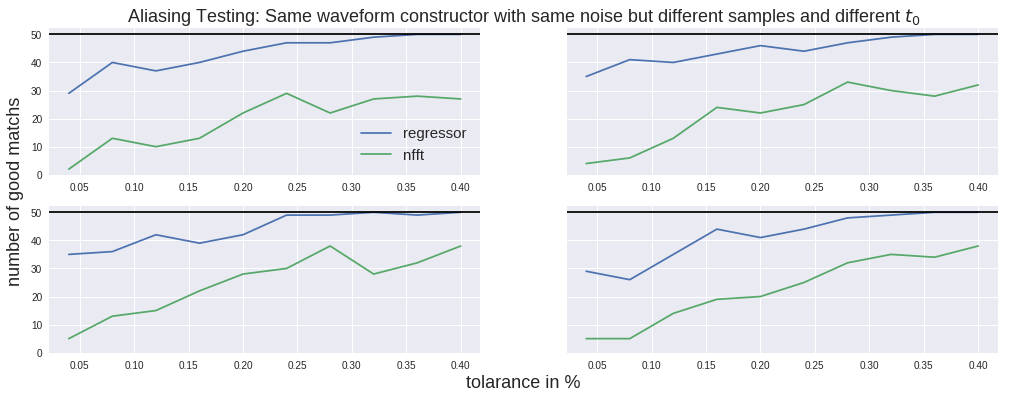

In [79]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(17, 6), sharey=True)
tol_arr = (np.arange(10)+1)*0.04

ax1.plot(tol_arr, basic_reg, label="regressor")
ax1.plot(tol_arr, basic_nfft, label="nfft")
ax1.legend(fontsize=15)
ax1.axhline(N, color='k')
ax2.plot(tol_arr, with_chi_reg)
ax2.plot(tol_arr, with_chi_nfft)
ax2.axhline(N, color='k')
ax3.plot(tol_arr, with_band_reg)
ax3.plot(tol_arr, with_band_nfft)
ax3.axhline(N, color='k')
ax4.plot(tol_arr, with_band_and_chi_reg)
ax4.plot(tol_arr, with_band_and_chi_nfft)
ax4.axhline(N, color='k')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("tolarance in %", fontsize=18)
plt.ylabel("number of good matchs", fontsize=18)
plt.title(r"Aliasing Testing: Same waveform constructor with same noise but different samples and different $t_0$", 
          fontsize=18)
plt.savefig("tol1.png")
# ax.set_xlabel("tolerance in \%")

In [82]:
# then repeat with same t0 for generating the data
n = 60
delta_t = 0.8
times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
times -= min(times)

N = 50
t0 = times[n//2]
basic_reg, basic_nfft = aliasing(times, pars, nsample, N, tol_factor=0.04, t0=t0)
with_chi_reg, with_chi_nfft = aliasing(times, pars, nsample, N, tol_factor=0.04, chi=True, t0=t0)
with_band_reg, with_band_nfft = aliasing(times, pars, nsample, N, tol_factor=0.04, band=True, t0=t0)
with_band_and_chi_reg, with_band_and_chi_nfft = aliasing(times, pars, nsample, N, tol_factor=0.04, 
                                                         chi=True, band=True, t0=t0)

0123456789012345678901234567890123456789

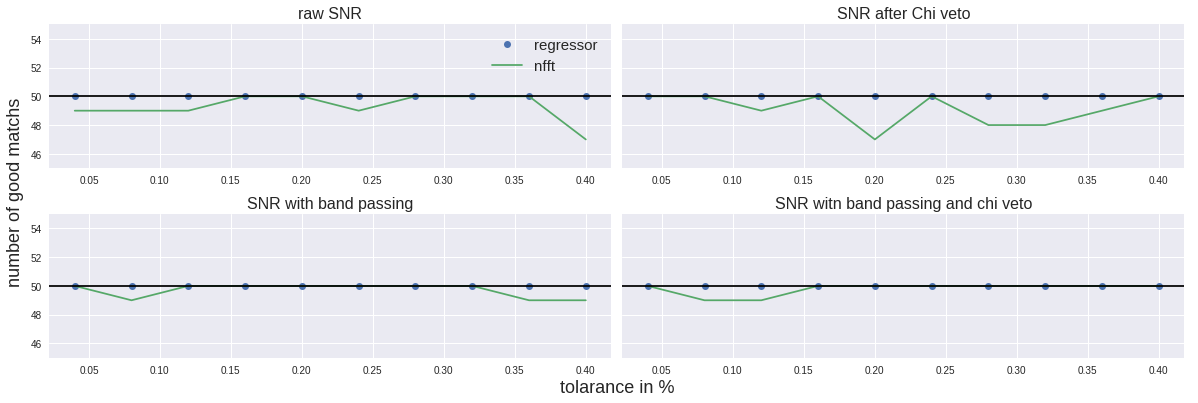

In [98]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(17, 6), sharey=True)
tol_arr = (np.arange(10)+1)*0.04

ax1.plot(tol_arr, basic_reg, 'o', label="regressor")
ax1.plot(tol_arr, basic_nfft, label="nfft")
ax1.legend(fontsize=15)
ax1.set_title("raw SNR", fontsize=16)
ax1.axhline(N, color='k')
ax1.set_ylim(45, 55)
ax2.plot(tol_arr, with_chi_reg, 'o')
ax2.plot(tol_arr, with_chi_nfft)
ax2.axhline(N, color='k')
ax2.set_title("SNR after Chi veto", fontsize=16)
ax2.set_ylim(45, 55)
ax3.plot(tol_arr, with_band_reg, 'o')
ax3.plot(tol_arr, with_band_nfft)
ax3.axhline(N, color='k')
ax3.set_title("SNR with band passing", fontsize=16)
ax3.set_ylim(45, 55)
ax4.plot(tol_arr, with_band_and_chi_reg, 'o')
ax4.plot(tol_arr, with_band_and_chi_nfft)
ax4.axhline(N, color='k')
ax4.set_title("SNR witn band passing and chi veto", fontsize=16)
ax4.set_ylim(45, 55)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("tolarance in %", fontsize=18)
plt.ylabel("number of good matchs", fontsize=18)
# plt.title(r"Aliasing Testing: Same waveform constructor with same noise but different samples and same $t_0$", 
#           fontsize=18)
plt.tight_layout()
plt.savefig("tol2.png")
# ax.set_xlabel("tolerance in \%")

#### Threshold study
now, for a given threshold we are going to see how many detections we get 

In [ ]:
def detection(times, pars, nsample, threshold, N, tol=0.04, chi=False, band=False, 
           window=False, psd=False, t0=None):
    reg_detect = 0
    nfft_detect = 0
    limit = times.duration * tol
    for i in range(N):
        data, temp, snr_reg, snr_nfft, t0 = one_run(times, pars, nsample, idx=idx, noise_level=0.1, chi=chi,
                                                   band=band, window=window, psd=psd, t0=t0)
        temp_reg = np.roll(temp, -np.argmax(snr_reg))
        temp_nfft = np.roll(temp, -np.argmax(snr_nfft))
        if abs(t0 - times[np.argmin(temp_reg)]) < limit:
            if max(snr_reg.real) >= threshold:
                goods_reg += 1
        if abs(t0 - times[np.argmin(temp_nfft)]) < limit:
            if max(snr_nfft.real) >= threshold:
                goods_nfft += 1
    
    goods_reg = 0
    goods_nfft = 0
    limit = times.duration * tol
    for i in range(N):
        data, temp, snr_reg, snr_nfft, t0 = one_run(times, pars, nsample, idx=idx, noise_level=0.1, chi=chi,
                                                   band=band, window=window, psd=psd, t0=t0)
        temp_reg = np.roll(temp, -np.argmax(snr_reg))
        temp_nfft = np.roll(temp, -np.argmax(snr_nfft))
        if abs(t0 - times[np.argmin(temp_reg)]) < limit:
            goods_reg += 1
        if abs(t0 - times[np.argmin(temp_nfft)]) < limit:
            goods_nfft += 1
    return goods_reg, goods_nfft

    repeat(times, pars, nsample, N, idx=15, tol=0.1, chi=False, band=False, 
           window=False, psd=False, t0=None)